# **East Africa drought study - model fitting**

In [254]:
source("../wwa_nonstationary_fitting.r")

# load precip data and convert to log for fitting purposes
# df <- read.csv("data/gmst-nino-chirps.csv")
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

---
## **Linear model fits**

- Choose parameters by fitting linear model & checking significance
- Treat GMST and Nino3.4rel as independent, since Nino index is detrended

In [255]:
df <- read.csv("data/gmst-nino-chirps.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v]))) # use log10 to match climate explorer

In [256]:
rbind.fill(sapply(colnames(df)[5:ncol(df)], function(v) {
    if(grepl("mam", v)) {
        nino = "nino_mam"
    } else {
        nino = "nino_ond"
    }
    summ_gmst <- summary(lm(get(v) ~ gmst, df))
    summ_nino <- summary(lm(get(v) ~ get(nino), df))
    summ_both <- summary(lm(get(v) ~ gmst + get(nino), df))
    
    data.frame("variable" = v, 
               # "nino_cov" = nino,
               "gmst" = c(paste0(round(summ_gmst$coefficients[-1,1], 4), c("", "*")[(summ_gmst$coefficients[-1,4] < 0.05) + 1])),
               "nino" = c(paste0(round(summ_nino$coefficients[-1,1], 4), c("", "*")[(summ_nino$coefficients[-1,4] < 0.05) + 1])),
               "both" = c(paste0(round(summ_both$coefficients[-1,1], 4), c("", "*")[(summ_both$coefficients[-1,4] < 0.05) + 1], collapse = " & ")))
}, simplify = F))

variable,gmst,nino,both
<chr>,<chr>,<chr>,<chr>
pr_ond,0.3217,0.1769*,0.4744* & 0.1931*
pr_mam,-0.1385,0.0359,-0.1203 & 0.0247
pr12,0.0586,0.0898*,0.1332 & 0.0944*
pr24,0.095,0.0266,0.121 & 0.0308


---
## **New methods used in this analysis**

In [257]:
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

# check fitted parameters against climate explorer to confirm working properly
round(fit_ns("norm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)  # expect 2.114, 0.193, 0.077
round(fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", lower = F)$par, 3)     # expect 25.848, 0.492, 0.990

mu0 sigma0  alpha   beta 
 2.114  0.193  0.074  0.000

mu0 sigma0  alpha   beta 
25.847  0.492  0.989  0.000

In [258]:
# also check that results match for lognormal fitting / normal fitting to log precip
df <- read.csv("data/gmst-nino-cpc.csv")
df["log_pr"] <- log(df$pr_ond)

round(fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)$par, 3)
round(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)

mu0 sigma0  alpha   beta 
 4.869  0.444  0.171  0.000

mu0 sigma0  alpha   beta 
 4.868  0.444  0.172  0.000

---
## **Bivariate analysis using ``copula`` package**

### **Test by replicating Mariam's analysis**

In [259]:
df <- read.csv("data/gmst-nino-cpc.csv")

In [260]:
# fit marginal distributions
# df["log_pr"] <- log10(df$pr_ond); mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)
mdl_pr <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)
mdl_tas <- fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr, mdl_pr$x)
u_tas <- map_to_u(mdl_tas, mdl_tas$x)

# fit copula to u,v pairs
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

In [266]:
jmodel_res(mdl_pr, mdl_tas, cfit, x = df[df$year == 2022, "pr_ond"], y = df[df$year == 2022, "pet_ond"], cov1_hist = df[df$year == 2022, "gmst"]-1.2)

,dist,fit_type,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,lnorm,fixeddisp,0.1722124,0,0.09114279,86.65775,71.98893,14.668810,FALSE,9.271601,4.824405,0.5203421
pet_ond ~ gmst,norm,shift,1.6295234,0,0.96122131,14.48540,12.52997,1.955428,FALSE,2.648938,105.492926,39.8246158
joint,tCopula,stationary,NA,NA,0.67661490,NA,NA,NA,NA,10.956372,119.183136,10.8779746


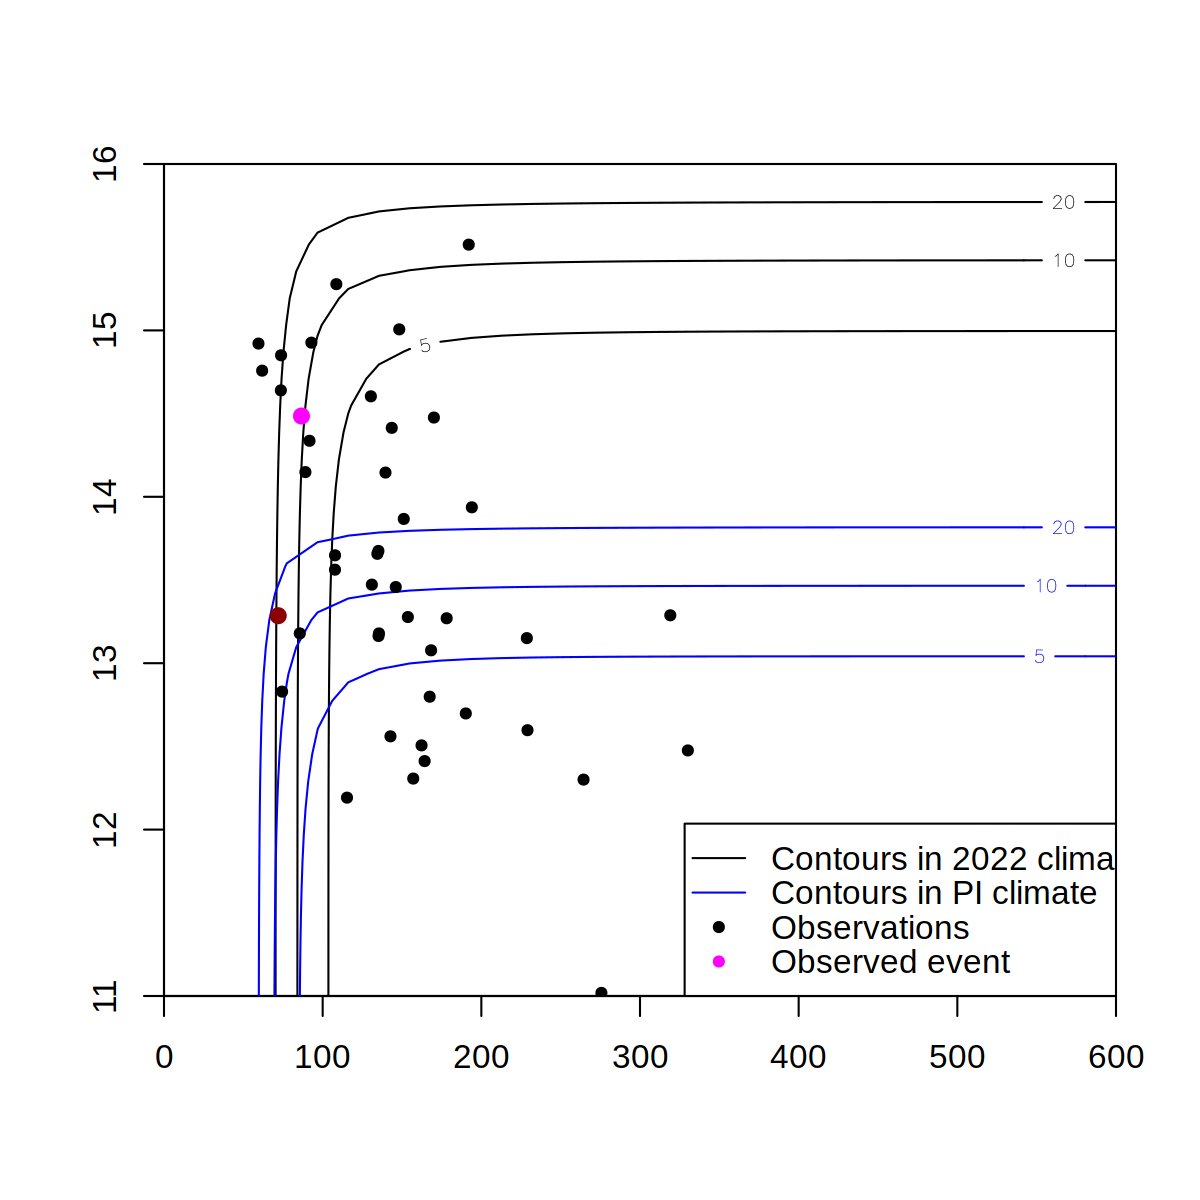

In [262]:
par(pch = 20, xaxs = "i", yaxs = "i")

contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022]), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)

# add event of same magnitude in historical climate
points(map_from_u(u_pr[df$year == 2022], mdl_pr, cov1 = df$gmst[df$year == 2022]-1.2),
       map_from_u(u_tas[df$year == 2022], mdl_tas, cov1 = df$gmst[df$year == 2022])-1.2, col = "darkred", cex = 1.5)

legend("bottomright", c("Contours in 2022 climate", "Contours in PI climate", "Observations", "Observed event"), col = c("black", "blue", "black", "magenta"), lty = c(1,1,NA,NA), pch = c(NA,NA,20,20))

### **Panel plot of fitted models**

- needs to be modified to work with new functions above

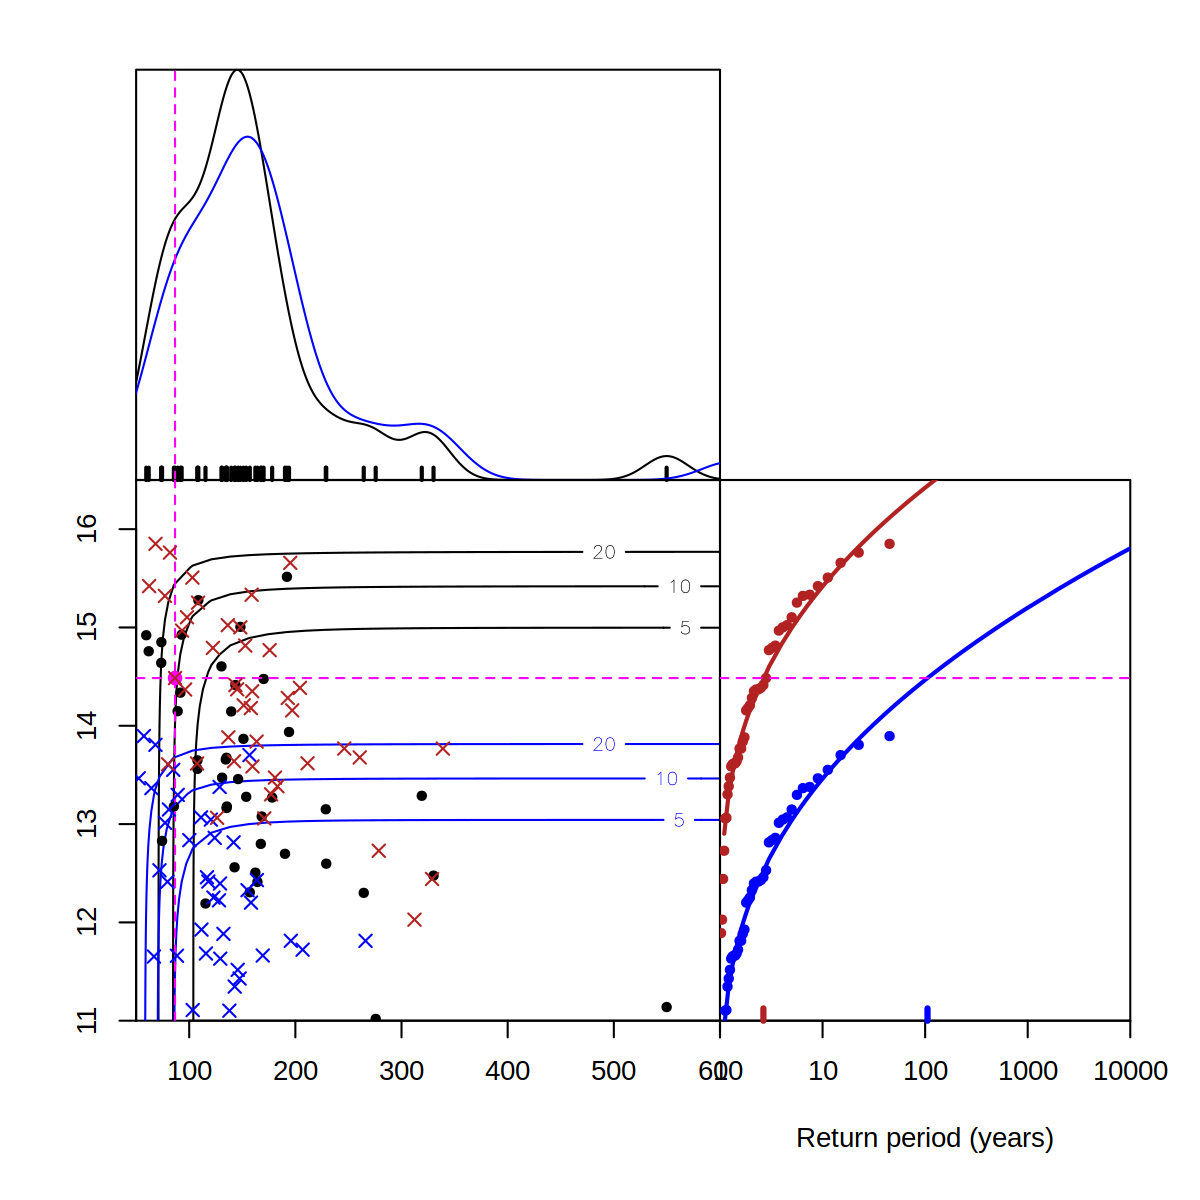

In [265]:
rc = c(1,1); w = 6; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, xaxs = "i", yaxs = "i")
layout(matrix(c(1,2,3,4),2,2), widths = c(3,2), heights = c(2,3))

xrange = c(50,600)
yrange = c(11,16.5)

par(mar = c(0,4.1,2.1,0))
plot(density(mdl_pr$x), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "black")
rug(mdl_pr$x, lwd = 2)
lines(density(map_from_u(map_to_u(mdl_pr), mdl_pr, cov1 = df$gmst[df$year == 2022])), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "blue")
abline(v = mdl_pr$x[df$year == "2022"], col = "magenta", lty = 2)
# plot_returnperiods(mdl_pr, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_pr$x[df$year == 2022])

par(mar = c(5.4,4.1,0,0))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022], xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2, xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)
abline(v = mdl_pr$x[df$year == 2022], h = mdl_tas$x[df$year == 2022], col = "magenta", lty = 2)

points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022] - 1.2), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] - 1.2), pch = 4, col = "blue")
points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022]), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] ), pch = 4, col = "firebrick")


plot.new()
# par(mar = c(0,0,2.1,2.1))
# contour(MASS::kde2d(map_to_u(mdl_pr), map_to_u(mdl_tas)), col = "skyblue", main = "", xaxt = "n", yaxt = "n")
# points(map_to_u(mdl_pr), map_to_u(mdl_tas), pch = 4, col = "cornflowerblue")
# contour(cfit, dCopula, add = T)

par(mar = c(5.4,0,0,2.1))
# plot.new()
# dns <- density(mdl_tas$x)
# dns_hist <- density(map_from_u(map_to_u(mdl_tas), mdl_tas, cov1 = df$gmst[df$year == 2022]))
# plot(dns$y, dns$x, yaxt = "n", xaxt = "n", xlab = "", ylim = yrange, type = "l", col = "black", xlim = range(c(dns$y, dns_hist$y)))
# rug(mdl_tas$x, side = 2, lwd = 2)
# abline(h = mdl_tas$x[df$year == "2022"], col = "magenta", lty = 2)
# lines(dns_hist$y, dns_hist$x, col = "blue")
plot_returnperiods(mdl_tas, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_tas$x[df$year == 2022], legend_pos = NA, yaxt = "n", ylim = yrange)

# probably better to replot with CDF on each axis? Or return level plot?

### **Fit & get results**

In [298]:
joint_model_qfit <- function(mdl_1, mdl_2, cov1_hist, cov2_hist = 0, x = NA, y = NA, dI_x_rel = F, dI_y_rel = F) {
    
    # fit copula to u,v pairs
    fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
    cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula
    
    if(is.na(x)) { x <- mdl_1$x[length(mdl_1$x)]}
    if(is.na(y)) { y <- mdl_2$x[length(mdl_2$x)]}
        
    res <- jmodel_res(mdl_1, mdl_2, cfit, x = x, y = y, cov1_hist = cov1_hist, cov2_hist = cov2_hist, dI_x_rel = dI_x_rel, dI_y_rel = dI_y_rel)
    return(res)
}

In [299]:
joint_model_qfit(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T), 
                 fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", lower = F),
                 cov1_hist = df$gmst[df$year == 2022]-1.2, dI_x_rel = T)

,dist,fit_type,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,lnorm,fixeddisp,0.1722124,0,0.09114279,86.65775,71.98893,20.376479,TRUE,9.271601,4.824405,0.5203421
pet_ond ~ gmst,norm,shift,1.6295234,0,0.96122131,14.48540,12.52997,1.955428,FALSE,2.648938,105.492926,39.8246158
joint,tCopula,stationary,NA,NA,0.67661490,NA,NA,NA,NA,10.956372,119.183136,10.8779746


In [300]:
joint_model_qfit(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), 
                 fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = F),
                 cov1_hist = df$gmst[df$year == 2022]-1.2, cov2_hist = df$nino_ond[df$year == 2022], dI_x_rel = T)

,dist,fit_type,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst + nino_ond,lnorm,fixeddisp,0.3071031,0.1834618,0.07978852,86.65775,52.67238,64.522177,TRUE,17.033852,2.351076,0.1380237
pet_ond ~ gmst + nino_ond,norm,shift,1.5445244,-0.1037183,0.95429278,14.48540,12.74517,1.740233,FALSE,2.779456,68.814816,24.7583748
joint,tCopula,stationary,NA,NA,0.64736402,NA,NA,NA,NA,19.603361,72.736896,3.7104298


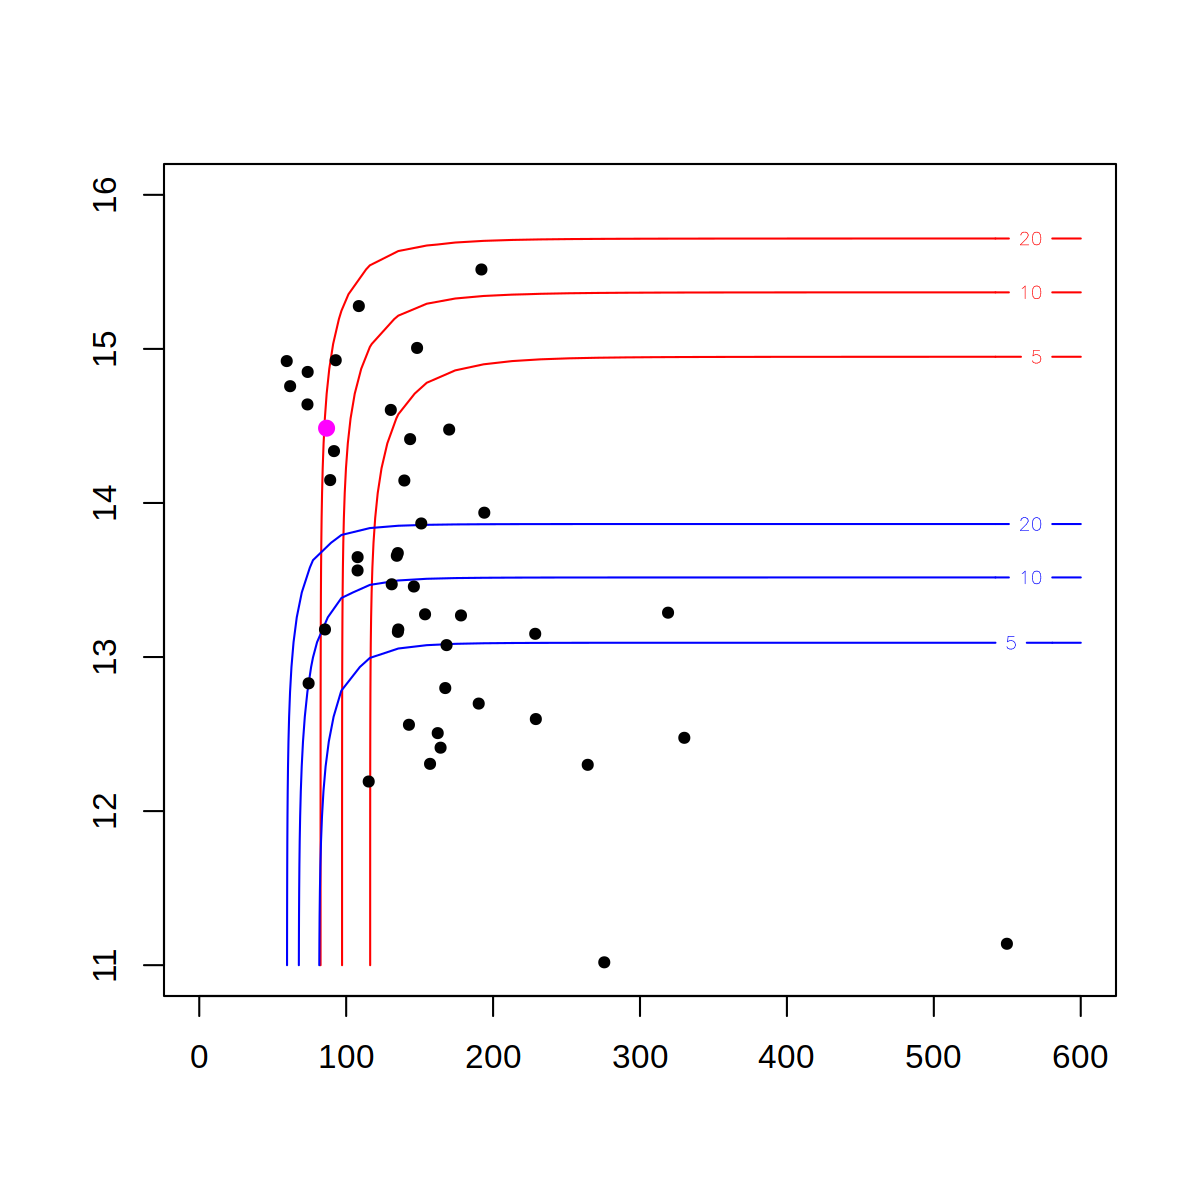

In [313]:
mdl_1 <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)
mdl_2 <- fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = F)

fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

contour(copula_mesh(mdl_1, mdl_2, cfit, df$gmst[df$year == 2022]), levels = 1/c(5,10,20), labels = c(5,10,20), col = "red")
contour(copula_mesh(mdl_1, mdl_2, cfit, df$gmst[df$year == 2022]-1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)

points(mdl_1$x, mdl_2$x, pch = 20)
points(mdl_1$x[df$year == 2022], mdl_2$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)